In [1]:
import nibabel as nb
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import pandas as pd
from scipy.stats import entropy
from sklearn.decomposition import DictionaryLearning
from scipy.stats import entropy

In [2]:
with open("data_saved.pkl", "rb") as file:
    loaded_dict = pickle.load(file)

[-24.45752651 -38.01550317 -42.00314336 -32.16696422 -27.91348135
 -38.28134585 -40.40808728 -28.17932403 -29.50853742 -38.01550317]


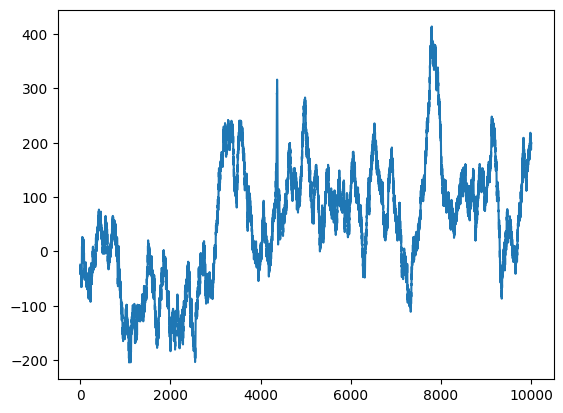

In [3]:
electrode_0_values = loaded_dict['electrode_0']
print(electrode_0_values[:10])
plt.plot(electrode_0_values[:10000])

/mnt/d_disk/ch22b007/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


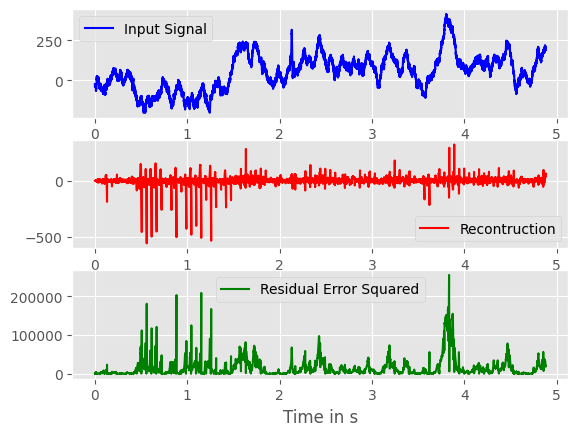

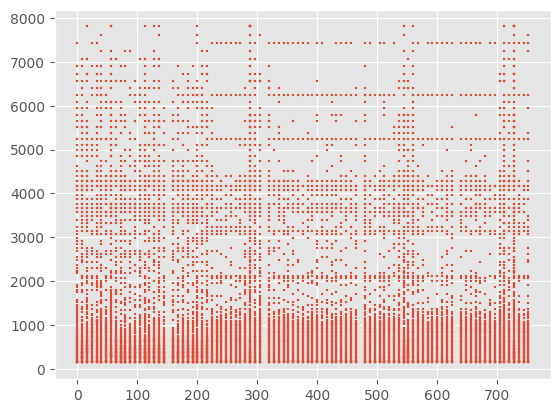

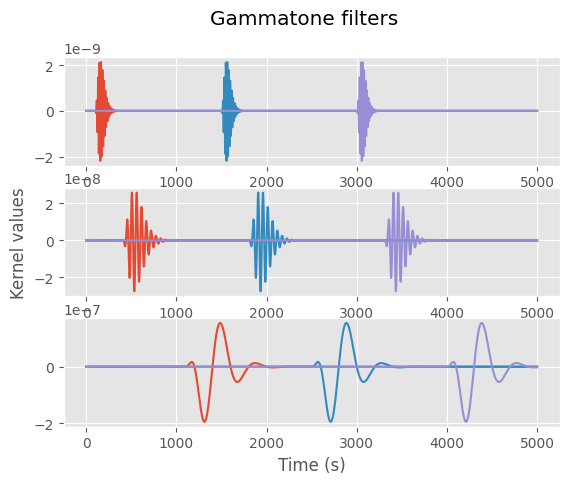

In [ ]:
from gammatone_utils import *
# from scikits.talkbox import segment_axis
# from scikits.audiolab import Sndfile, play
import soundfile as sf
import sounddevice as sd
import pydub 
from pydub import AudioSegment
from pydub.playback import play
import matplotlib.pyplot as plt
# from encoding import * 
plt.style.use('ggplot')

def matching_pursuit(signal, dict_kernels, threshold=0.1, max_iter=2000):
    """
    Matching pursuit algorithm for encoding
    :param signal: input signal
    :param dict_kernels: dictionary of kernels, each column is a kernel
    :param threshold: stop condition
    :param max_iter: maximum number of iterations
    :return: array of scalar weighting factor (one per kernel)
    """
    # Initialization
    res = signal
    coeff = np.zeros(dict_kernels.shape[0])
    # Iterative decomposition
    for i in range(max_iter):
        inner_prod = res.dot(dict_kernels.T)
        max_kernel = np.argmax(inner_prod)
        coeff[max_kernel] = inner_prod[max_kernel] / np.linalg.norm(dict_kernels[max_kernel,: ])**2
        res = res - coeff[max_kernel] * dict_kernels[max_kernel,: ]
        if np.linalg.norm(res) < threshold:
            return coeff
    return coeff

def segment_axis(arr, frame_size, overlap, end='pad'):
    step = frame_size - overlap
    if end == 'pad':
        pad_width = (frame_size - (len(arr) % step)) % frame_size
        arr = np.pad(arr, (0, pad_width), mode='constant')
    
    return np.lib.stride_tricks.sliding_window_view(arr, frame_size)[::step]

# Parametrization
b = 1.019
resolution = 160
step = 8
n_channels = 128
overlap = 50

# Compute gammatone-based dictionary
D_multi = np.r_[tuple(gammatone_matrix(b, fc, resolution, step)[0] for
                      fc in erb_space(150, 8000, n_channels))]
freq_c = np.array([gammatone_matrix(b, fc, resolution, step)[1] for
                      fc in erb_space(150, 8000, n_channels)]).flatten()
centers = np.array([gammatone_matrix(b, fc, resolution, step)[2] + i*resolution  for
                      i, fc in enumerate(erb_space(150, 8000, n_channels))]).flatten()

# Load test signal
# filename = 'TEST/DR1/FAKS0/SX403.wav'
# f = Sndfile(filename, 'r')
# f, samplerate1 = sf.read(filename)

# f = sf.SoundFile(filename)
f = electrode_0_values[:10000]
nf = len(f) # f.nframes
# fs = samplerate1
fs = 2048
length_sound = 10000
# y = f.read(frames = length_sound)
y = electrode_0_values[:10000]
# y = f.read_frames(length_sound)

Y = segment_axis(y, resolution, overlap=overlap, end='pad')
Y = np.hanning(resolution) * Y

# Encoding with matching pursuit
X = np.zeros((Y.shape[0],D_multi.shape[0]))
for idx in range(Y.shape[0]):
    X[idx, :] = matching_pursuit(Y[idx, :], D_multi)

# Reconstruction of the signal
out = np.zeros(int((np.ceil(len(y)/resolution)+1)*resolution))
for k in range(0, len(X)):
    idx = range(k*(resolution-overlap), k*(resolution-overlap) + resolution)
    out[idx] += np.dot(X[k], D_multi)
squared_error = np.sum((y - out[0:len(y)]) ** 2)

# Play the original signal and the reconstructed for comparison
# play(y, fs=16000)
# play(out, fs=16000)

# sd.play(y, fs=16000)
# sd.play(out, fs=16000)

# Plotting results

# 1st plot: original signal/reconstructed signal/residuals
arr = np.array(range(length_sound))/float(fs)
plt.figure(1)
plt.subplot(311)
plt.plot(arr, y, 'b', label="Input Signal")
plt.legend()
plt.subplot(312)
plt.plot(arr, out[0:len(y)], 'r', label="Recontruction")
plt.legend()
plt.subplot(313)
plt.plot(arr, (y - out[0:len(y)])**2, 'g', label="Residual Error Squared")
plt.legend()
plt.xlabel("Time in s")
plt.show()

# 2nd plot: spike train
plt.figure(2)
spikes_pos = np.array(np.nonzero(X))
temporal_position = centers[spikes_pos[0][:]]
centre_freq = freq_c[spikes_pos[1][:]]
plt.scatter(temporal_position, centre_freq, marker='+', s=1)
plt.show()

# 3rd plot: example of gammatone-based dictionary
fig = plt.figure(3)
fig.suptitle("Gammatone filters", fontsize="x-large")
freqs = [1000, 300, 40]
resolution = 5000
for center in [100, 1500, 3000]:
    plt.subplot(311)
    plt.plot(gammatone_function(resolution, freqs[0], center), linewidth=1.5)
    plt.subplot(312)
    plt.plot(gammatone_function(resolution, freqs[1], center+300), linewidth=1.5)
    plt.ylabel("Kernel values")
    plt.subplot(313)
    plt.plot(gammatone_function(resolution, freqs[2], center+1000), linewidth=1.5)
    plt.xlabel("Time (s)")
plt.show()


In [5]:
filename = 'TEST/DR1/FAKS0/SX403.wav'
f = sf.SoundFile(filename)
a = f.read()